## **Real Time Face Mask Detector**

### **Importing the Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
import seaborn as sns

### **Creating CNN Model**

In [ ]:
model = Sequential()
model.add(Convolution2D(128, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Convolution2D(100, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dropout(0.20))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 100)       115300    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 129600)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 129600)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

### **Image Augumentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_face_mask/train/train',
                                                  target_size = (150, 150),
                                                  batch_size = 10)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_face_mask/test/test',
                                                  target_size = (150, 150),
                                                  batch_size = 10)
hist = model.fit(training_set,
                 epochs = 10,
                 validation_data = test_set)

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.
Epoch 1/10
132/132 [==============================] - 228s 2s/step - loss: 0.7196 - accuracy: 0.7915 - val_loss: 0.2675 - val_accuracy: 0.9072
Epoch 2/10
132/132 [==============================] - 230s 2s/step - loss: 0.3423 - accuracy: 0.8539 - val_loss: 0.2476 - val_accuracy: 0.8918
Epoch 3/10
132/132 [==============================] - 226s 2s/step - loss: 0.2624 - accuracy: 0.9011 - val_loss: 0.2226 - val_accuracy: 0.9124
Epoch 4/10
132/132 [==============================] - 229s 2s/step - loss: 0.2120 - accuracy: 0.9237 - val_loss: 0.1989 - val_accuracy: 0.9278
Epoch 5/10
132/132 [==============================] - 226s 2s/step - loss: 0.1630 - accuracy: 0.9354 - val_loss: 0.1540 - val_accuracy: 0.9588
Epoch 6/10
132/132 [==============================] - 225s 2s/step - loss: 0.1369 - accuracy: 0.9566 - val_loss: 0.1174 - val_accuracy: 0.9485
Epoch 7/10
132/132 [==============================] - 228s 

In [ ]:
model.save('model-010.h5')
print("Model Saved Successfully")

Model Saved Successfully


### **Data Visualization**

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

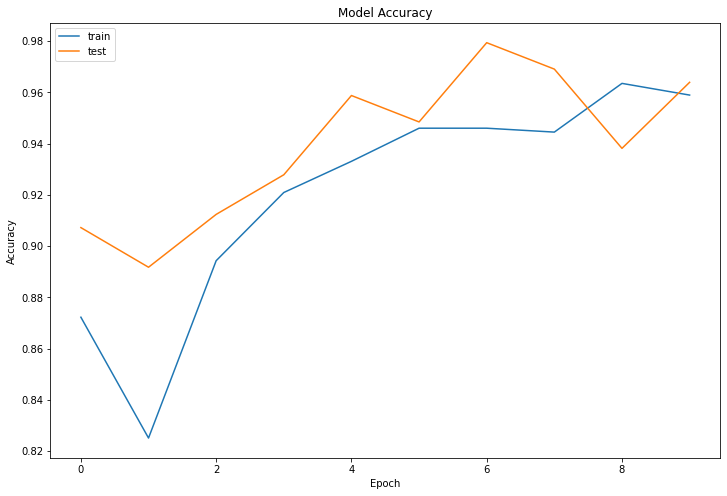

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

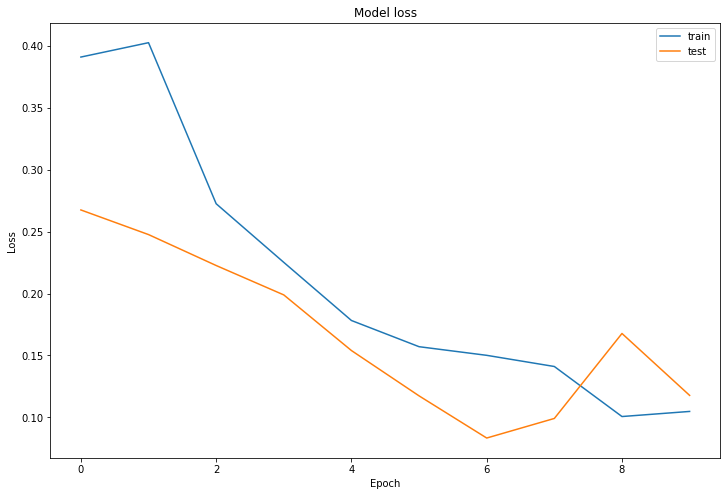

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### **Testing the results of face mask detector model using OpenCV.**

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
model=load_model("/content/model-010.h5")

results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0) 


haarcascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')

while True:
    (rval, im) = cap.read()
    im = cv2.flip(im , 1, 1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150, 150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1, 150, 150, 3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('Face Mask Detector',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()